## Regresi Linear dan Polinomial untuk Penetapan Harga Labu - Pelajaran 3

Muatkan perpustakaan dan dataset yang diperlukan. Tukarkan data kepada dataframe yang mengandungi subset data:

- Hanya ambil labu yang dihargai mengikut unit bushel
- Tukarkan tarikh kepada bulan
- Kira harga sebagai purata daripada harga tinggi dan rendah
- Tukarkan harga untuk mencerminkan penetapan harga mengikut kuantiti bushel


In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

pumpkins = pd.read_csv('../../data/US-pumpkins.csv')
pumpkins.head()

City Name Type       Package      Variety Sub Variety  Grade     Date  \
0  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN  4/29/17   
1  BALTIMORE  NaN  24 inch bins          NaN         NaN    NaN   5/6/17   
2  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
3  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  9/24/16   
4  BALTIMORE  NaN  24 inch bins  HOWDEN TYPE         NaN    NaN  11/5/16   

   Low Price  High Price  Mostly Low  ...  Unit of Sale Quality Condition  \
0      270.0       280.0       270.0  ...           NaN     NaN       NaN   
1      270.0       280.0       270.0  ...           NaN     NaN       NaN   
2      160.0       160.0       160.0  ...           NaN     NaN       NaN   
3      160.0       160.0       160.0  ...           NaN     NaN       NaN   
4       90.0       100.0        90.0  ...           NaN     NaN       NaN   

  Appearance Storage  Crop Repack  Trans Mode  Unnamed: 24  Unnamed: 25  
0        NaN     NaN   NaN      E         NaN          NaN          NaN  
1        NaN     NaN   NaN      E         NaN          NaN          NaN  
2        NaN     NaN   NaN      N         NaN          NaN          NaN  
3        NaN     NaN   NaN      N         NaN          NaN          NaN  
4        NaN     NaN   NaN      N         NaN          NaN          NaN  

[5 rows x 26 columns]

In [168]:
pumpkins = pumpkins[pumpkins['Package'].str.contains('bushel', case=True, regex=True)]

new_columns = ['Package', 'Variety', 'City Name', 'Month', 'Low Price', 'High Price', 'Date']
pumpkins = pumpkins.drop([c for c in pumpkins.columns if c not in new_columns], axis=1)

price = (pumpkins['Low Price'] + pumpkins['High Price']) / 2

month = pd.DatetimeIndex(pumpkins['Date']).month
day_of_year = pd.to_datetime(pumpkins['Date']).apply(lambda dt: (dt-datetime(dt.year,1,1)).days)

new_pumpkins = pd.DataFrame(
    {'Month': month, 
     'DayOfYear' : day_of_year, 
     'Variety': pumpkins['Variety'], 
     'City': pumpkins['City Name'], 
     'Package': pumpkins['Package'], 
     'Low Price': pumpkins['Low Price'],
     'High Price': pumpkins['High Price'], 
     'Price': price})

new_pumpkins.loc[new_pumpkins['Package'].str.contains('1 1/9'), 'Price'] = price/1.1
new_pumpkins.loc[new_pumpkins['Package'].str.contains('1/2'), 'Price'] = price*2

new_pumpkins.head()


Month  DayOfYear   Variety       City               Package  Low Price  \
70      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   
71      9        267  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
72     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       18.0   
73     10        274  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       17.0   
74     10        281  PIE TYPE  BALTIMORE  1 1/9 bushel cartons       15.0   

    High Price      Price  
70        15.0  13.636364  
71        18.0  16.363636  
72        18.0  16.363636  
73        17.0  15.454545  
74        15.0  13.636364

Plot taburan mengingatkan kita bahawa kita hanya mempunyai data bulan dari Ogos hingga Disember. Kita mungkin memerlukan lebih banyak data untuk dapat membuat kesimpulan secara linear.


<AxesSubplot:xlabel='Month', ylabel='Price'>

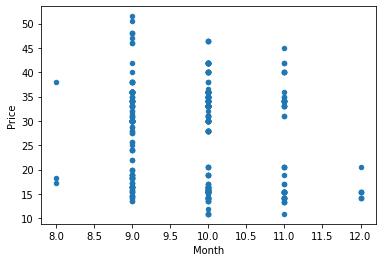

In [169]:
new_pumpkins.plot.scatter('Month','Price')

<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

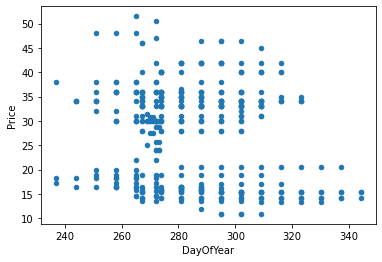

In [170]:
new_pumpkins.plot.scatter('DayOfYear','Price')

In [171]:
print(new_pumpkins['Month'].corr(new_pumpkins['Price']))
print(new_pumpkins['DayOfYear'].corr(new_pumpkins['Price']))

-0.14878293554077535
-0.16673322492745407


Nampaknya korelasi agak kecil, tetapi terdapat hubungan lain yang lebih penting - kerana titik harga dalam plot di atas kelihatan mempunyai beberapa kelompok yang berbeza. Mari kita buat plot yang akan menunjukkan pelbagai jenis labu:


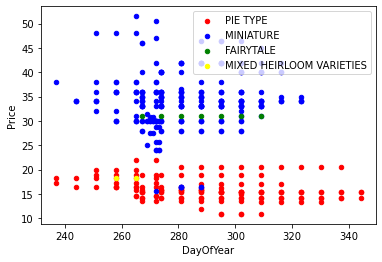

In [172]:
ax=None
colors = ['red','blue','green','yellow']
for i,var in enumerate(new_pumpkins['Variety'].unique()):
    ax = new_pumpkins[new_pumpkins['Variety']==var].plot.scatter('DayOfYear','Price',ax=ax,c=colors[i],label=var)

<AxesSubplot:xlabel='Variety'>

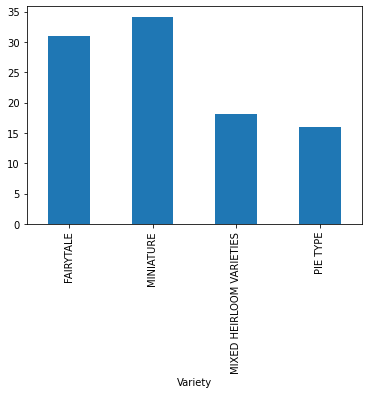

In [173]:
new_pumpkins.groupby('Variety')['Price'].mean().plot(kind='bar')

-0.2669192282197318


<AxesSubplot:xlabel='DayOfYear', ylabel='Price'>

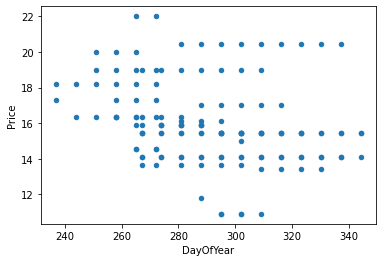

In [174]:
pie_pumpkins = new_pumpkins[new_pumpkins['Variety']=='PIE TYPE']
print(pie_pumpkins['DayOfYear'].corr(pie_pumpkins['Price']))
pie_pumpkins.plot.scatter('DayOfYear','Price')

### Regresi Linear

Kita akan menggunakan Scikit Learn untuk melatih model regresi linear:


In [175]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

In [176]:
X = pie_pumpkins['DayOfYear'].to_numpy().reshape(-1,1)
y = pie_pumpkins['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)

pred = lin_reg.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')


Mean error: 2.77 (17.2%)


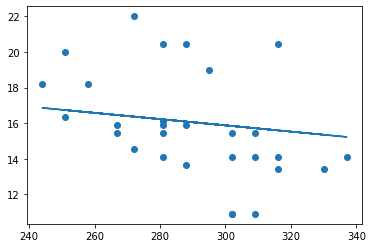

In [177]:
plt.scatter(X_test,y_test)
plt.plot(X_test,pred)

Kecerunan garis boleh ditentukan daripada pekali regresi linear:


In [178]:
lin_reg.coef_, lin_reg.intercept_

(array([-0.01751876]), 21.133734359909326)

Kita boleh menggunakan model yang telah dilatih untuk meramalkan harga:


In [179]:
# Pumpkin price on programmer's day

lin_reg.predict([[256]])

array([16.64893156])

### Regresi Polinomial

Kadangkala hubungan antara ciri-ciri dan hasil adalah secara semula jadi tidak linear. Sebagai contoh, harga labu mungkin tinggi pada musim sejuk (bulan=1,2), kemudian menurun pada musim panas (bulan=5-7), dan kemudian meningkat semula. Regresi linear tidak dapat mencari hubungan ini dengan tepat.

Dalam kes ini, kita boleh mempertimbangkan untuk menambah ciri-ciri tambahan. Cara mudah adalah dengan menggunakan polinomial daripada ciri input, yang akan menghasilkan **regresi polinomial**. Dalam Scikit Learn, kita boleh secara automatik mengira ciri-ciri polinomial menggunakan pipelines:


Mean error: 2.73 (17.0%)
Model determination:  0.07639977655280217


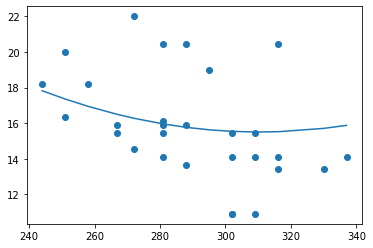

In [180]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

plt.scatter(X_test,y_test)
plt.plot(sorted(X_test),pipeline.predict(sorted(X_test)))

### Pengekodan jenis

Dalam dunia ideal, kita ingin dapat meramalkan harga untuk pelbagai jenis labu menggunakan model yang sama. Untuk mengambil kira jenis, kita perlu menukarkannya kepada bentuk angka terlebih dahulu, atau **mengekod**. Terdapat beberapa cara untuk melakukannya:

* Pengekodan angka mudah yang akan membina jadual jenis yang berbeza, dan kemudian menggantikan nama jenis dengan indeks dalam jadual tersebut. Ini bukan idea terbaik untuk regresi linear, kerana regresi linear mengambil nilai angka indeks sebagai faktor, dan nilai angka tersebut mungkin tidak berkorelasi secara numerik dengan harga.
* Pengekodan satu-haba (one-hot encoding), yang akan menggantikan lajur `Variety` dengan 4 lajur berbeza, satu untuk setiap jenis, yang akan mengandungi 1 jika baris yang sepadan adalah jenis tertentu, dan 0 jika tidak.

Kod di bawah menunjukkan bagaimana kita boleh mengekod satu-haba untuk jenis:


In [181]:
pd.get_dummies(new_pumpkins['Variety'])

FAIRYTALE  MINIATURE  MIXED HEIRLOOM VARIETIES  PIE TYPE
70            0          0                         0         1
71            0          0                         0         1
72            0          0                         0         1
73            0          0                         0         1
74            0          0                         0         1
...         ...        ...                       ...       ...
1738          0          1                         0         0
1739          0          1                         0         0
1740          0          1                         0         0
1741          0          1                         0         0
1742          0          1                         0         0

[415 rows x 4 columns]

### Regresi Linear pada Variasi

Kita akan menggunakan kod yang sama seperti di atas, tetapi kali ini, bukannya `DayOfYear`, kita akan menggunakan variasi yang telah diubah kepada satu-hot-encoded sebagai input:


In [182]:
X = pd.get_dummies(new_pumpkins['Variety'])
y = new_pumpkins['Price']

In [183]:
def run_linear_regression(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train,y_train)

    pred = lin_reg.predict(X_test)

    mse = np.sqrt(mean_squared_error(y_test,pred))
    print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

    score = lin_reg.score(X_train,y_train)
    print('Model determination: ', score)

run_linear_regression(X,y)

Mean error: 5.24 (19.7%)
Model determination:  0.774085281105197


Kita juga boleh cuba menggunakan ciri-ciri lain dengan cara yang sama, dan menggabungkannya dengan ciri-ciri berangka, seperti `Month` atau `DayOfYear`:


In [184]:
X = pd.get_dummies(new_pumpkins['Variety']) \
        .join(new_pumpkins['Month']) \
        .join(pd.get_dummies(new_pumpkins['City'])) \
        .join(pd.get_dummies(new_pumpkins['Package']))
y = new_pumpkins['Price']

run_linear_regression(X,y)

Mean error: 2.84 (10.5%)
Model determination:  0.9401096672643048


### Regresi Polinomial

Regresi polinomial juga boleh digunakan dengan ciri kategori yang telah dikodkan satu-panas. Kod untuk melatih regresi polinomial pada dasarnya akan sama seperti yang telah kita lihat di atas.


In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(PolynomialFeatures(2), LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

pipeline.fit(X_train,y_train)

pred = pipeline.predict(X_test)

mse = np.sqrt(mean_squared_error(y_test,pred))
print(f'Mean error: {mse:3.3} ({mse/np.mean(pred)*100:3.3}%)')

score = pipeline.score(X_train,y_train)
print('Model determination: ', score)

Mean error: 2.23 (8.25%)
Model determination:  0.9652870784724543



---

**Penafian**:  
Dokumen ini telah diterjemahkan menggunakan perkhidmatan terjemahan AI [Co-op Translator](https://github.com/Azure/co-op-translator). Walaupun kami berusaha untuk memastikan ketepatan, sila ambil maklum bahawa terjemahan automatik mungkin mengandungi kesilapan atau ketidaktepatan. Dokumen asal dalam bahasa asalnya harus dianggap sebagai sumber yang berwibawa. Untuk maklumat yang kritikal, terjemahan manusia profesional adalah disyorkan. Kami tidak bertanggungjawab atas sebarang salah faham atau salah tafsir yang timbul daripada penggunaan terjemahan ini.
